# Using an MLP to learn the K-MNIST Dataset

In [337]:
import numpy as np
import random 
import seaborn as sns

import matplotlib.pyplot as plt 
import tensorflow as tf

from tensorflow.keras import utils
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten

from tensorflow.keras.optimizers import Adam, Nadam, SGD # SGD = Stochastic Gradient Descent

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [338]:
data_train = np.load('kmnist-train-imgs.npz')
labels_train = np.load('kmnist-train-labels.npz')
data_test = np.load('kmnist-test-imgs.npz')
labels_test = np.load('kmnist-test-labels.npz')

In [339]:
k_train_samples = data_train['arr_0']
k_train_labels = labels_train['arr_0']
k_test_samples = data_test['arr_0']
k_test_labels = labels_test['arr_0']

k_train_samples.shape

(60000, 28, 28)

In [340]:
X_train = k_train_samples.reshape(60000, 784) 
X_test = k_test_samples.reshape(10000, 784)   

X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

X_train /= 255                        
X_test /= 255

X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [341]:
# Check for NaN values
np.isnan(X_train).any()

False

In [359]:
no_classes = 10

#Y_train = utils.to_categorical(k_train_labels, no_classes)
#Y_test = utils.to_categorical(k_test_labels, no_classes)

Y_train = k_train_labels
Y_test = k_test_labels

# One-Hot Encode the vectors

#Y_train = tf.one_hot(k_train_labels.astype(np.int32), depth=10)
#Y_test = tf.one_hot(k_test_labels.astype(np.int32), depth=10)

In [360]:
# Build a Sequential, Densely connected network

model_working = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
 #tf.keras.layers.Dense(128, activation='relu'), 
  tf.keras.layers.Dense(400, activation='relu'), 
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [361]:
# Get the output of the model

predictions = model_working(X_train[:1]).numpy()
predictions

array([[ 0.42327988, -0.01962653,  0.11214513,  0.6360147 , -0.12694399,
        -0.01092994,  0.11217222, -0.7575911 ,  0.81423575, -0.24980094]],
      dtype=float32)

In [362]:
# Convert these to probabilities using the softmax activation function

tf.nn.softmax(predictions).numpy()

array([[0.12715189, 0.08165278, 0.0931534 , 0.15729408, 0.07334384,
        0.08236598, 0.09315593, 0.03903706, 0.1879805 , 0.06486457]],
      dtype=float32)

In [363]:
# Use the cross entropy loss function to get a loss value
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [364]:
# Calcualte loss for each index of the predictions, using the corresponding output label

loss_fn(Y_train[:1], predictions).numpy()

1.671417

In [366]:
# Configure and compile the model using model.compile

model_working.compile(optimizer='nadam',
              loss=loss_fn,
              metrics=['acc']) # this means that we have to do History.history['acc']

In [367]:
# Define Hyperparameters
batch_size = 64
epochs = 5

In [368]:
# Define a function that'll stop training IF we reach 99.5% accuracy
# This is important so our model doesn't over-generalize to our data-set

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') is not None and logs.get('acc') > 0.995): # add the "is not None"
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [369]:
# Train and evaluate the model

history = model_working.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 8s 8ms/step - loss: 0.4202 - acc: 0.8742 - val_loss: 0.2393 - val_acc: 0.9312
Epoch 2/5
844/844 [==============================] - 9s 10ms/step - loss: 0.1994 - acc: 0.9421 - val_loss: 0.1909 - val_acc: 0.9437
Epoch 3/5
844/844 [==============================] - 8s 10ms/step - loss: 0.1389 - acc: 0.9587 - val_loss: 0.1552 - val_acc: 0.9542
Epoch 4/5
844/844 [==============================] - 8s 10ms/step - loss: 0.1052 - acc: 0.9686 - val_loss: 0.1442 - val_acc: 0.9577
Epoch 5/5
844/844 [==============================] - 9s 10ms/step - loss: 0.0810 - acc: 0.9761 - val_loss: 0.1436 - val_acc: 0.9595


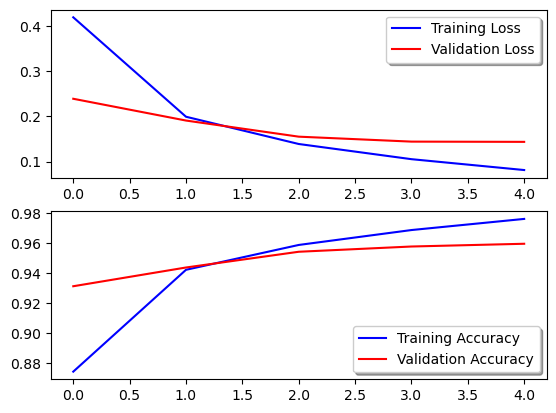

In [370]:
# Evaluate the model:

# Loss and Accuracy Curves

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## ------------------ Hyperparameter Search --------------------------- 

In [187]:
# Make different models that we can train different hyper-paramters on- 2 are single-hidden layer, 2 are double-hidden layer

models = []
layer_width = []
for i in range(1,5):
    lw = 40
    # Define a NEW model
    model = Sequential()
    #model._name = "MLP " + str(i)
    # Now start adding layers to this NEW model
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    if i >= 3:
        # make the last couple of models multi-layer
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    layer_width.append(lw)
    models.append(model)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_36 (Flatten)        (None, 784)               0         
                                                                 
 dense_84 (Dense)            (None, 128)               100480    
                                                                 
 dropout_48 (Dropout)        (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              P

In [199]:
print(len(models))

4


In [205]:
# Hyperparameters
batch_size = [32, 64, 128, 256]
num_epochs = 5

#lr = [0.1]
lr = [0.0001, 0.001, 0.01, 0.1, 1]
#m = [0.9]
#m = [0.0001, 0.001, 0.01, 0.1, 1]
chosen_lr = []
chosen_m = []

loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) # because we'll apply the softmax function ourselves

def searchHyperparameters(model):
    
    model_tuples = []
    
    print('For model....', model._name)
    print('\n\n')
    
    for i in range(len(lr)):
        temp_lr = lr[i]
        #temp_m = m[i]
        #chosen_lr.append(temp_lr)
        #chosen_m.append(temp_m)
        opt = Nadam(learning_rate=temp_lr)
        model.compile(optimizer=opt, loss=loss_fn1, metrics=['accuracy']) # instead of loss='categorical_crossentropy'
        for j in range(len(batch_size)):
            temp_batch = batch_size[j]
            
            history = model.fit(X_train, Y_train,
                    batch_size=temp_batch,
                    epochs=num_epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])
            #histories.append(history)
            model_tuples.append((model, temp_lr, temp_batch, history))
    return model_tuples

In [206]:
# finally, the container to hold the result of every combination:
model0_tuples = searchHyperparameters(models[0])
model1_tuples = searchHyperparameters(models[1])
model2_tuples = searchHyperparameters(models[2])
model3_tuples = searchHyperparameters(models[3])


For model.... sequential_38



Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1873 - accuracy: 0.9456 - val_loss: 0.1987 - val_accuracy: 0.9428
Epoch 2/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1802 - accuracy: 0.9481 - val_loss: 0.1934 - val_accuracy: 0.9447
Epoch 3/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1730 - accuracy: 0.9488 - val_loss: 0.1917 - val_accuracy: 0.9448
Epoch 4/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1681 - accuracy: 0.9513 - val_loss: 0.1868 - val_accuracy: 0.9467
Epoch 5/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1616 - accuracy: 0.9531 - val_loss: 0.1842 - val_accuracy: 0.9478
Epoch 1/5
844/844 [==============================] - 6s 7ms/step - loss: 0.1550 - accuracy: 0.9556 - val_loss: 0.1809 - val_accuracy: 0.9482
Epoch 2/5
844/844 [==============================] - 6s 7ms/step - loss: 0.1537 - accuracy: 0.9542 - val_loss: 0.

211/211 [==============================] - 2s 9ms/step - loss: 0.1071 - accuracy: 0.9657 - val_loss: 0.3163 - val_accuracy: 0.9428
Epoch 4/5
211/211 [==============================] - 2s 9ms/step - loss: 0.1009 - accuracy: 0.9675 - val_loss: 0.3265 - val_accuracy: 0.9442
Epoch 5/5
211/211 [==============================] - 2s 8ms/step - loss: 0.1080 - accuracy: 0.9653 - val_loss: 0.3160 - val_accuracy: 0.9433
Epoch 1/5
1688/1688 [==============================] - 12s 6ms/step - loss: 2.0386 - accuracy: 0.3773 - val_loss: 1.9328 - val_accuracy: 0.2712
Epoch 2/5
1688/1688 [==============================] - 10s 6ms/step - loss: 2.1194 - accuracy: 0.2291 - val_loss: 1.9783 - val_accuracy: 0.2273
Epoch 3/5
1688/1688 [==============================] - 10s 6ms/step - loss: 2.0974 - accuracy: 0.2302 - val_loss: 2.4924 - val_accuracy: 0.2607
Epoch 4/5
1688/1688 [==============================] - 10s 6ms/step - loss: 2.0691 - accuracy: 0.2278 - val_loss: 2.1729 - val_accuracy: 0.2827
Epoch 5/5
1

422/422 [==============================] - 3s 8ms/step - loss: 0.2330 - accuracy: 0.9323 - val_loss: 0.2383 - val_accuracy: 0.9335
Epoch 1/5
211/211 [==============================] - 2s 9ms/step - loss: 0.2288 - accuracy: 0.9341 - val_loss: 0.2361 - val_accuracy: 0.9325
Epoch 2/5
211/211 [==============================] - 2s 8ms/step - loss: 0.2252 - accuracy: 0.9353 - val_loss: 0.2341 - val_accuracy: 0.9350
Epoch 3/5
211/211 [==============================] - 2s 8ms/step - loss: 0.2204 - accuracy: 0.9361 - val_loss: 0.2317 - val_accuracy: 0.9340
Epoch 4/5
211/211 [==============================] - 2s 8ms/step - loss: 0.2196 - accuracy: 0.9371 - val_loss: 0.2286 - val_accuracy: 0.9370
Epoch 5/5
211/211 [==============================] - 2s 8ms/step - loss: 0.2153 - accuracy: 0.9371 - val_loss: 0.2262 - val_accuracy: 0.9357
Epoch 1/5
1688/1688 [==============================] - 10s 5ms/step - loss: 0.2450 - accuracy: 0.9256 - val_loss: 0.2051 - val_accuracy: 0.9385
Epoch 2/5
1688/1688 

Epoch 3/5
422/422 [==============================] - 3s 8ms/step - loss: 1.9019 - accuracy: 0.2891 - val_loss: 1.9185 - val_accuracy: 0.3317
Epoch 4/5
422/422 [==============================] - 3s 8ms/step - loss: 1.9116 - accuracy: 0.2853 - val_loss: 1.8526 - val_accuracy: 0.3025
Epoch 5/5
422/422 [==============================] - 3s 8ms/step - loss: 1.9064 - accuracy: 0.2780 - val_loss: 1.8131 - val_accuracy: 0.3330
Epoch 1/5
211/211 [==============================] - 2s 9ms/step - loss: 1.8760 - accuracy: 0.2992 - val_loss: 1.8698 - val_accuracy: 0.3538
Epoch 2/5
211/211 [==============================] - 2s 9ms/step - loss: 1.8448 - accuracy: 0.3077 - val_loss: 1.8420 - val_accuracy: 0.3398
Epoch 3/5
211/211 [==============================] - 2s 8ms/step - loss: 1.8369 - accuracy: 0.3131 - val_loss: 1.9127 - val_accuracy: 0.3472
Epoch 4/5
211/211 [==============================] - 2s 8ms/step - loss: 1.8386 - accuracy: 0.3022 - val_loss: 2.0266 - val_accuracy: 0.3392
Epoch 5/5
211

844/844 [==============================] - 6s 7ms/step - loss: 0.1135 - accuracy: 0.9629 - val_loss: 0.1526 - val_accuracy: 0.9578
Epoch 1/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0892 - accuracy: 0.9709 - val_loss: 0.1482 - val_accuracy: 0.9580
Epoch 2/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0835 - accuracy: 0.9729 - val_loss: 0.1516 - val_accuracy: 0.9562
Epoch 3/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0800 - accuracy: 0.9739 - val_loss: 0.1502 - val_accuracy: 0.9590
Epoch 4/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0831 - accuracy: 0.9726 - val_loss: 0.1483 - val_accuracy: 0.9580
Epoch 5/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0802 - accuracy: 0.9735 - val_loss: 0.1554 - val_accuracy: 0.9567
Epoch 1/5
211/211 [==============================] - 2s 11ms/step - loss: 0.0697 - accuracy: 0.9776 - val_loss: 0.1539 - val_accuracy: 0.9598
Epoch 2/5
211/211 [===

Epoch 3/5
844/844 [==============================] - 6s 7ms/step - loss: 2.3411 - accuracy: 0.0995 - val_loss: 2.3337 - val_accuracy: 0.0963
Epoch 4/5
844/844 [==============================] - 6s 7ms/step - loss: 2.3398 - accuracy: 0.1016 - val_loss: 2.3534 - val_accuracy: 0.1027
Epoch 5/5
844/844 [==============================] - 6s 7ms/step - loss: 2.3677 - accuracy: 0.1011 - val_loss: 2.3580 - val_accuracy: 0.1027
Epoch 1/5
422/422 [==============================] - 4s 9ms/step - loss: 2.3425 - accuracy: 0.1010 - val_loss: 2.3235 - val_accuracy: 0.1027
Epoch 2/5
422/422 [==============================] - 4s 8ms/step - loss: 2.3292 - accuracy: 0.1026 - val_loss: 2.3291 - val_accuracy: 0.1027
Epoch 3/5
422/422 [==============================] - 4s 8ms/step - loss: 2.3254 - accuracy: 0.0994 - val_loss: 2.3246 - val_accuracy: 0.1000
Epoch 4/5
422/422 [==============================] - 4s 8ms/step - loss: 2.3271 - accuracy: 0.0971 - val_loss: 2.3369 - val_accuracy: 0.1052
Epoch 5/5
422

1688/1688 [==============================] - 11s 7ms/step - loss: 0.4531 - accuracy: 0.8819 - val_loss: 0.3783 - val_accuracy: 0.9028
Epoch 1/5
844/844 [==============================] - 6s 7ms/step - loss: 0.3368 - accuracy: 0.9097 - val_loss: 0.2845 - val_accuracy: 0.9232
Epoch 2/5
844/844 [==============================] - 6s 7ms/step - loss: 0.2991 - accuracy: 0.9163 - val_loss: 0.2901 - val_accuracy: 0.9252
Epoch 3/5
844/844 [==============================] - 6s 7ms/step - loss: 0.3148 - accuracy: 0.9157 - val_loss: 0.2791 - val_accuracy: 0.9253
Epoch 4/5
844/844 [==============================] - 6s 7ms/step - loss: 0.3122 - accuracy: 0.9149 - val_loss: 0.3038 - val_accuracy: 0.9210
Epoch 5/5
844/844 [==============================] - 6s 7ms/step - loss: 0.3247 - accuracy: 0.9141 - val_loss: 0.3404 - val_accuracy: 0.9167
Epoch 1/5
422/422 [==============================] - 4s 9ms/step - loss: 0.2492 - accuracy: 0.9298 - val_loss: 0.2529 - val_accuracy: 0.9388
Epoch 2/5
422/422 [=

In [306]:
def givenTupleFindBestModel(model_tuple):
    
    best_model = []
            
    for i in range(len(model_tuple)):
        accuracy = model_tuple[i][3].history['accuracy'][-1]
        val_accuracy = model_tuple[i][3].history['val_accuracy'][-1]
        diff = accuracy - val_accuracy
        best_model.append(diff)
        
    index = np.argmin(best_model)
    best_model_tuple = model_tuple[index]
    
    return best_model_tuple

In [307]:
best_model0 = givenTupleFindBestModel(model0_tuples)
best_model1 = givenTupleFindBestModel(model1_tuples)
best_model2 = givenTupleFindBestModel(model2_tuples)
best_model3 = givenTupleFindBestModel(model3_tuples)

# among the best models for each architecture, choose the best one based off loss

print(best_model0[3].history['loss'])
print(best_model1[3].history['loss'])
print(best_model2[3].history['loss'])
print(best_model3[3].history['loss'])
print('\n')
print(best_model0[3].history['accuracy'])
print(best_model1[3].history['accuracy'])
print(best_model2[3].history['accuracy'])
print(best_model3[3].history['accuracy'])



[1.881571650505066, 1.895057201385498, 1.8835006952285767, 1.900296688079834, 1.8671091794967651]
[1.956063985824585, 1.9256565570831299, 1.9018514156341553, 1.911605954170227, 1.9063514471054077]
[1.1065723896026611, 0.5987036824226379, 0.4824787676334381, 0.41818109154701233, 0.37527745962142944]
[1.088547945022583, 0.6030150651931763, 0.4878914952278137, 0.41932013630867004, 0.3729603886604309]


[0.28114813566207886, 0.2853148281574249, 0.2805185317993164, 0.28733333945274353, 0.2849629521369934]
[0.26911109685897827, 0.27577778697013855, 0.28905555605888367, 0.2853333353996277, 0.2780185043811798]
[0.654703676700592, 0.8172962665557861, 0.8532037138938904, 0.8729259371757507, 0.88485187292099]
[0.6588147878646851, 0.8175740838050842, 0.8522962927818298, 0.8713518381118774, 0.887759268283844]


In [304]:
print(best_model3[0].history.history['accuracy'])

[0.0996851846575737, 0.0996851846575737, 0.0996851846575737, 0.0996851846575737, 0.09918518364429474]


### Clearly, best_model_3 had the lowest loss and the highest accuracy, so use this

In [175]:
find_best_model = []
for history in histories:
    find_best_model.append(history.history['loss'][-1])

index = np.argmin(find_best_model)
best_history = histories[index]

print("best_history.history is\n", best_history.history)
print('\nParameters of Best Model are:', best_history.params)
print("Chosen Model: " + str(index))
print("Final Loss: " + str(find_best_model[index]))
print("Final Accuracy: " + str(histories[index].history['accuracy'][-1]))
print("Final Learning Rate: " + str(chosen_lr[index]))
print("Final Momentum: " + str(chosen_m[index]))
print("Layer Width: " + str(layer_width[index]))

best_history.history is
 {'loss': [0.05282144621014595, 0.04873587563633919, 0.04988094046711922, 0.04833664745092392, 0.04464662820100784], 'accuracy': [0.9830555319786072, 0.9845185279846191, 0.9844074249267578, 0.9847777485847473, 0.9858333468437195], 'val_loss': [0.16542798280715942, 0.16843494772911072, 0.16517865657806396, 0.16884291172027588, 0.1675056368112564], 'val_accuracy': [0.9574999809265137, 0.9556666612625122, 0.9564999938011169, 0.9574999809265137, 0.9558333158493042]}

Parameters of Best Model are: {'verbose': 1, 'epochs': 5, 'steps': 211}
Chosen Model: 27
Final Loss: 0.04464662820100784
Final Accuracy: 0.9858333468437195


IndexError: list index out of range

In [352]:
best_model = best_model3[0]
print(best_model._name)

print(best_model3[2])

sequential_41
32


In [353]:
# retrain the model
opt = Nadam(learning_rate=best_model3[1])
best_model.compile(optimizer=opt, loss=loss_fn1, metrics=['accuracy']) # instead of loss='categorical_crossentropy'
best_model.fit(X_train, Y_train,
                    batch_size=best_model3[2],
                    epochs=num_epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
1688/1688 [==============================] - 8s 4ms/step - loss: 2.3026 - accuracy: 0.0989 - val_loss: 2.3027 - val_accuracy: 0.0950
Epoch 2/5
1688/1688 [==============================] - 9s 5ms/step - loss: 2.3026 - accuracy: 0.0993 - val_loss: 2.3027 - val_accuracy: 0.0950
Epoch 3/5
1688/1688 [==============================] - 10s 6ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.0950
Epoch 4/5
1688/1688 [==============================] - 9s 5ms/step - loss: 2.3026 - accuracy: 0.1002 - val_loss: 2.3027 - val_accuracy: 0.0955
Epoch 5/5
1688/1688 [==============================] - 9s 5ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.0950


## --------------------------------------------------------------------------------

In [371]:
# Use evaluate() function to check model performance

model_working.evaluate(X_test,  Y_test, verbose=2)

313/313 - 1s - loss: 0.3614 - acc: 0.8994 - 502ms/epoch - 2ms/step


[0.3613634407520294, 0.899399995803833]

In [372]:
# if we want our model to return a probability, attach output to a softmax layer
#probability_model = tf.keras.Sequential([
#  best_model,
#  tf.keras.layers.Softmax()
#])

In [373]:
# get a sample value for the probability
# probability_model(X_test[:5])

In [374]:
# Make the confusion Matrix

# Predict the values from the testing dataset
Y_pred = model_working.predict(X_test)
print(X_test.shape)
print(Y_pred.shape)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
print(Y_pred_classes.shape)
# Convert testing observations to one hot vectors
#print('y_tests shape is', Y_test.shape)
# Y_true = np.argmax(Y_test, axis = 1)
#print('Y_trues shape is', Y_true.shape)
# compute the confusion matrix

confusion_mtx = tf.math.confusion_matrix(Y_test, Y_pred_classes)
# confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)
# confusion_mtx = tf.math.confusion_matrix(Y_test, Y_pred)

313/313 [==============================] - 1s 1ms/step
(10000, 28, 28, 1)
(10000, 10)
(10000,)


<Axes: >

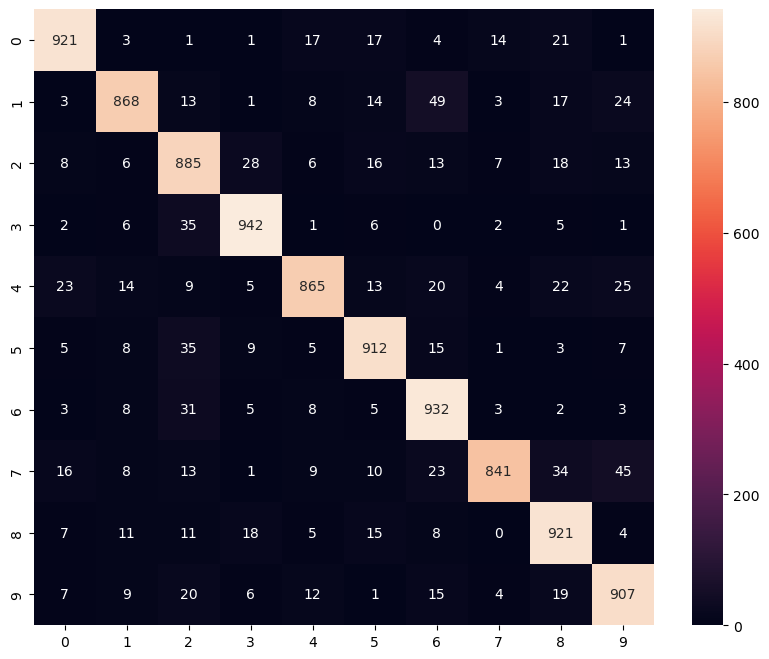

In [375]:
# Plot Confusion Matrix

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

In [142]:
predicted_classes = model.predict(X_test)
predicted_labels = np.argmax(predicted_classes,axis=1)

#true_labels = np.argmax(Y_test,axis=1)
true_labels = Y_test

print("Accuracy: " + str(accuracy_score(true_labels, predicted_labels)))
print("Weighted Precision: " + str(precision_score(true_labels, predicted_labels, average='weighted')))
print("Weighted Recall: " + str(recall_score(true_labels, predicted_labels, average='weighted')))
print("Weighted F1 Score: " + str(f1_score(true_labels, predicted_labels, average='weighted')))

313/313 [==============================] - 0s 1ms/step
Accuracy: 0.8899
Weighted Precision: 0.8916660999384327
Weighted Recall: 0.8899
Weighted F1 Score: 0.8900117546898019
